In [1]:
import graph as gr
import numpy as np
import networkx as nx

import torch
torch.manual_seed(12121998)
import torch.nn.functional as F

from torch.nn import Linear, ReLU
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GATConv
from torch_geometric.nn.models import basic_gnn as torch_models

import matplotlib.pyplot as plt
import matplotlib.tri as tri

import time

# Creating Dataset

In [2]:
# Macros

NORMALIZE_TARGET_FLAG = True # normalize output!
if NORMALIZE_TARGET_FLAG:
    norm_inter = [0, 1] # Interval where to normalize data

COORDINATES_FEATURE_FLAG = False # If true also position is used as feature!

In [3]:
# FILENAMES AND FILEPATH

# mesh name
mesh_filename = "simple_laplacian_mesh"

## target filepaths
target_filepaths = ["../mesh/simple_laplacian_u.txt"] # you can add other targets

## feature filepaths 
feature_filepaths = ["../mesh/simple_laplacian_f.txt"]

In [4]:
folder = gr.import_mesh(mesh_filename)

loaded_graph = gr.build_graph(folder)

loaded_adj = gr.build_adjacency(loaded_graph, folder)

loaded_targets = [torch.tensor(0)] * len(target_filepaths)
for i, data in enumerate(target_filepaths):
    loaded_targets[i] = torch.tensor(gr.import_features(data)).double()

loaded_features = [torch.tensor(0)] * len(feature_filepaths)
for i, data in enumerate(feature_filepaths):
    loaded_features[i] = torch.tensor(gr.import_features(data)).double()


if NORMALIZE_TARGET_FLAG:
    u_max = [None] * len(loaded_targets)
    u_min = [None] * len(loaded_targets)
    for i, data in enumerate(loaded_targets):
        u_max[i] = data.max()
        u_min[i] = data.min()
        loaded_targets[i] = (norm_inter[1] - norm_inter[0]) * (data - u_min[i]) / (u_max[i] - u_min[i]) + norm_inter[0]  


TOT_SAMPLES = loaded_targets[0].shape[1]

In [5]:
## Creating torch DATASET (see torch_geometric.data)

# will be used to create the complete dataset
data_list = [torch.tensor(0)] * TOT_SAMPLES

# INITIALIZING COMMON PROPERTIES TO ALL GRAPHS

# Graph connectivity (# use t().contiguous() ...)
edge_index = torch.tensor([ [i,j] for i in range(loaded_adj.shape[0]) for j in range(loaded_adj.shape[1]) if loaded_adj[i,j]>0 ])

# Node position matrix ( ACTUALLY, IT SHOULD NOT BE NEEDED SINCE IT'S CONSTANT ... )
# check whether pos is used in the training or not. In the second case it's useless for dynamic meshes
pos = torch.hstack( (
                        torch.unsqueeze(torch.tensor(list(nx.get_node_attributes(loaded_graph, 'x').values())), 1 ),
                        torch.unsqueeze(torch.tensor(list(nx.get_node_attributes(loaded_graph, 'y').values())), 1 ) 
                    )
                  ).double()

# INITIALIZING THE DIFFERENT GRAPHS

for t in range(TOT_SAMPLES):
    
    ## Node feature matrix
    
    # REMOVED TYPE OF NODE FEATURE!
    # first feature (type of node)
    #x = torch.unsqueeze(torch.tensor(list(nx.get_node_attributes(loaded_graph, 'n').values())), 1).double()
    
    x = loaded_features[0][:, t][:, None]

    # other features (forcing f values)
    [x := torch.hstack((x, loaded_features[j][:, t][:, None])) for j in range(1,len(loaded_features))]
    
    if COORDINATES_FEATURE_FLAG:
        [x := torch.hstack((x, pos))]
    
    
    ## Node-level ground-truth labels (heat)
    
    # first feature (pression or velocity or ...)
    y = loaded_targets[0][:, t][:, None]
    
    # other features (pression, velocities, ...)
    [y := torch.hstack((y, loaded_targets[j][:, t][:, None])) for j in range(1,len(loaded_targets))]

    data_list[t] = Data(x=x, edge_index=edge_index.t().contiguous(), y=y, pos=pos)

In [6]:
dataloader = DataLoader(data_list, batch_size = 1, shuffle = True)

# Model

In [7]:
input_size = dataloader.dataset[0].num_nodes
output_size = dataloader.dataset[0].num_nodes
feature_size = dataloader.dataset[0].x.size()[-1]


In [8]:
class FFNN(torch.nn.Module):
    
    def __init__(self):
        super(FFNN, self).__init__()
        self.linear_relu = torch.nn.Sequential(
            #Linear(input_size * feature_size, output_size)
            Linear(input_size * feature_size, 512),
            ReLU(),
            Linear(512, 512),
            ReLU(),
            Linear(512, output_size),
        )


    def forward(self, x):
        x = torch.flatten(x)
        x = self.linear_relu(x)
        x = torch.tanh(x)
        
        return x

# Initializing the model
FFNN_model = FFNN().double()
print(FFNN_model)

FFNN(
  (linear_relu): Sequential(
    (0): Linear(in_features=1089, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=1089, bias=True)
  )
)


In [9]:
learning_rate = 1e-3

loss_fn = torch.nn.MSELoss()

optimizer = torch.optim.Adam(FFNN_model.parameters(), lr=learning_rate, weight_decay=1e-5)

In [10]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    loss = 0
    count = 0
    for batch, data in enumerate(dataloader):
        # Compute prediction and loss
        count += 1
        pred = model(data.x)
        loss = loss_fn(pred, data.y[:, 0])
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss += loss.item()
        #if count == 500:
            #break
    print("loss: {}".format(loss))

In [11]:
epochs = 10

start = time.time()

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(dataloader, FFNN_model, loss_fn, optimizer)
print("Done!")

end = time.time()
elapsed_time = end - start
minutes = elapsed_time//60
seconds = elapsed_time - 60*minutes
print("Elapsed time: ", int(minutes), "min, ", seconds, "sec")


Epoch 1
-------------------------------
loss: 0.0008445097005797801
Epoch 2
-------------------------------
loss: 0.00012065376434294617
Epoch 3
-------------------------------
loss: 0.001059997966686306
Epoch 4
-------------------------------
loss: 0.0006063877993038165
Epoch 5
-------------------------------
loss: 0.0001701692099012172
Epoch 6
-------------------------------
loss: 3.682851870153004e-05
Epoch 7
-------------------------------
loss: 4.474165774697283e-06
Epoch 8
-------------------------------
loss: 5.245468571168419e-05
Epoch 9
-------------------------------
loss: 0.0002012938981644378
Epoch 10
-------------------------------
loss: 1.854375408578516e-05
Done!
Elapsed time:  3 min,  32.57040786743164 sec


In [12]:
pred = (FFNN_model(dataloader.dataset[999]['x']) - norm_inter[0]) / (norm_inter[1] - norm_inter[0]) * (u_max[0] - u_min[0]) + u_min[0]
pred = torch.tensor(pred)
print("Prediction: ")
print(pred)

Prediction: 
tensor([0.9999, 1.0038, 1.0004,  ..., 3.4996, 3.5805, 3.6571],
       dtype=torch.float64)


/tmp/ipykernel_14869/1952943550.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.tensor(pred)


In [13]:
true = ((data_list[999].y) - norm_inter[0]) / (norm_inter[1] - norm_inter[0]) * (u_max[0] - u_min[0]) + u_min[0]
true = torch.tensor(true[:, 0])
print("True values: ")
print(true)

True values: 
tensor([1.0000, 1.0000, 1.0004,  ..., 3.7360, 3.8637, 4.0000],
       dtype=torch.float64)


/tmp/ipykernel_14869/1515962011.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true = torch.tensor(true[:, 0])


In [14]:

def error(pred, true):
    # Mean Absolute Error
    L1_loss = torch.nn.L1Loss()
    MAE = L1_loss(true, pred).item()
    print("Mean Absolute Error: ", MAE)

    # Mean Squared Error
    L2_loss = torch.nn.L1Loss()
    MSE = L2_loss(true, pred).item()
    print("Mean Squared Error: ", MSE)

    # Absolute Error in each node
    err = abs(true - pred)

    # Min Error
    min_err = err.min().item()
    print("Min error: ", min_err)

    # Max Error
    max_err = err.max().item()
    print("Max error: ", max_err)   

    # Mean Error
    mean_err = err.mean().item()
    print("Average error: ", mean_err)

    ret = {
        "MAE": MAE,
        "MSE": MSE, 
        "min_err": min_err,
        "max_err": max_err,
        "mean_err": mean_err 
    }
    return ret
    
err = error(pred, true)


Mean Absolute Error:  0.024592095771328787
Mean Squared Error:  0.024592095771328787
Min error:  5.888691454458694e-06
Max error:  0.3429078584252059
Average error:  0.024592095771328787


In [15]:
def plot(dataloader, output):
    plt.figure()
    
    # plots a finite element mesh
    def plot_fem_mesh(nodes_x, nodes_y, elements):
        for element in elements:
            x = [nodes_x[element[i]] for i in range(len(element))]
            y = [nodes_y[element[i]] for i in range(len(element))]
            plt.fill(x, y, edgecolor='black', fill=False, linewidth='0.5')

    # FEM data
    nodes_x = dataloader.dataset[0]['pos'][:,0]
    nodes_y = dataloader.dataset[0]['pos'][:,1]
    nodal_values = output # loaded_features[0][:, 0]
    elements = np.load(folder+"/triangles.npy")
    triangulation = tri.Triangulation(nodes_x, nodes_y, elements)

    # plot the contours
    plt.tricontourf(triangulation,  nodal_values)

    # plot the finite element mesh
    plot_fem_mesh(nodes_x, nodes_y, elements)

    # show
    plt.colorbar()
    plt.axis('equal')
    plt.show()

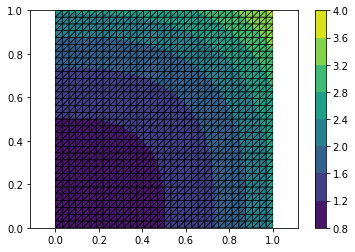

In [16]:
# Prediction plot
plot(dataloader, pred)

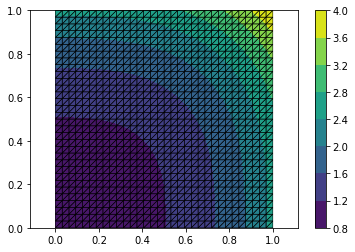

In [17]:
plot(dataloader, true)